# Versioned Image Generation

In this example, we create a custom text2image component in enact that uses a
two-step generative process in which:
1. an LLM elaborates the user prompt into prompt-ese,
2. an image is then generated from the LLM output prompt.

This notebook demonstrates how enact can be used to keep versioned storage of 
generative executions, which refer back to the precise component configuration
used to generate them.

## Prerequisites

Executing this notebook requires two API keys:
* A [replicate API key](https://replicate.com/account/api-tokens), to access the
Kandinsky diffusion model.
* An [OpenAI API key](https://platform.openai.com/account/api-keys), to access
the `gpt3.5-turbo` version of ChatGPT.

These are expected in files `~/openai.key` and `~/replicate.key`
(where `~/` refers to the user home directory, e.g., `/home/USER_NAME/`
on linux or mac or `C:\Users\USER_NAME` on windows.)

Note: The API calls in this notebook can take a while sometimes up to a minute
or more, so be patient.

In [1]:
# Check whether the required API keys are available.

import common

_ = common.OPENAI_API_KEY.get()
_ = common.REPLICATE_API_KEY.get()

## Creating an enact text2image component.

The common module defines functions that call the OpenAI and replicate APIs.
Now let's create enact invokables for these, so that we can track their
executions:

In [3]:
import enact
import dataclasses
from PIL.Image import Image

@enact.typed_invokable(str, str)
@dataclasses.dataclass
class GPT(enact.Invokable[str, str]):
  system_prompt: str
  def call(self, task_prompt: str):
    result = common.chat_gpt([
      ('system', self.system_prompt),
      ('user', task_prompt)])
    return result

@enact.typed_invokable(str, Image)
class Kandinsky(enact.Invokable[str, Image]):
  def call(self, prompt: str):
    return common.kandinsky(prompt)

We now instantiate a GPT component that performs prompt refinement...

In [4]:
prompt_refiner = GPT(
'''
You will receive a user prompt that indicates a type of image to create. 
Respond with an elaborated version of the user prompt that is suitable for use
in a text-to-image model.

Adhere closely to these instructions. Only respond with the refined prompt and
say nothing else.
''')

... and we create a generative component that calls the prompt refiner
and feeds the result into Kandinsky:

In [5]:
@enact.typed_invokable(str, Image)
@dataclasses.dataclass
class Text2Image(enact.Invokable[str, Image]):
  prompt_refiner: enact.Invokable[str, str]
  img_gen: enact.Invokable[str, Image]

  def call(self, prompt: str):
    refined_prompt = self.prompt_refiner(prompt)
    return self.img_gen(refined_prompt)

text2image = Text2Image(
  prompt_refiner=prompt_refiner,
  img_gen=Kandinsky())

Let's see this in action. We could simply run `text2image('a cat')`, but we will
_invoke_ `text2image` instead, which creates a journaled execution called an 
`invocation`. This has a few advantages. For one, we'll be able to analyze the
execution to see exactly which generated prompt led to the creation of the final
image.  Additionally, inputs, outputs, invokables and execution details are
persisted, so we can inspect them at a later point, e.g., to find out which task
descriptions work best.

We will use a `FileStore`, which stores all relevant resources in a target
directory.

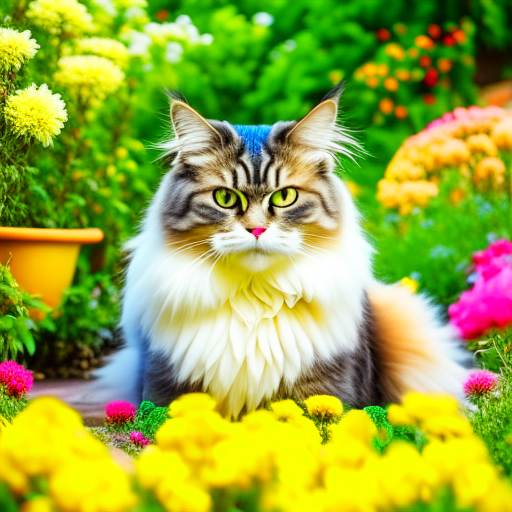

In [6]:
with enact.FileStore('./store_data') as store:
  prompt = enact.commit('a cat')   # persist the input to disk.
  invocation = text2image.invoke(prompt)      # generate an image.
  output = invocation.get_output()
output

Nice, but it doesn't quite have the signature look of AI art. Let's see what
kind of prompts our prompt refiner generates. Since the whole execution is
journaled in the invocation object this is pretty easy:

In [7]:
with store:
  # Fetch the first subinvocation, i.e., the first call made into another
  # invokable object.
  prompt_refiner_invocation = invocation.get_child(0)
  # Print the output of the prompt refiner step.
  print(prompt_refiner_invocation.get_output())
  

Please generate an image of a cute and fluffy cat with bright, expressive eyes, sitting gracefully on a soft cushion, surrounded by colorful flowers in a beautiful garden.


It looks like GPT does not understand what a typical prompt looks like and we
need to provide more guidance if we want our cat images to trend on artstation,
so let's append an example to the task description and try again.

refined prompt: exquisite and detailed rendering of a majestic cat, with piercing and captivating eyes, sleek and luxurious fur, gracefully poised, in the style of Audra Auclair and Loish, soft and diffused lighting, high resolution and intricate details, evoking a sense of mystery and elegance, award-winning composition, currently featured in galleries and exhibitions.


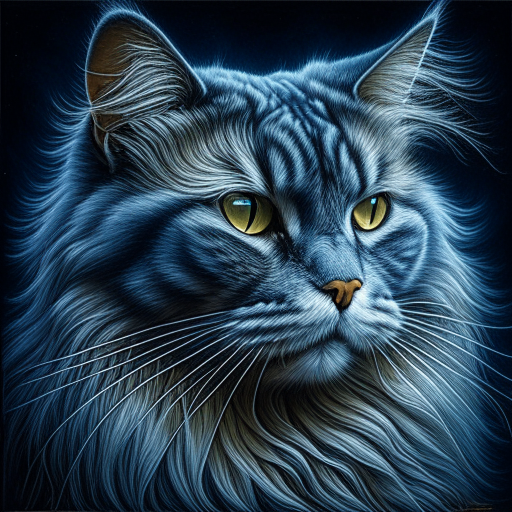

In [9]:
# Add example to system prompt:
prompt_refiner.system_prompt += '''\nFor example, if the user says "dog", you
may respond with: "beautiful illustration of a dog, gorgeous, amazing, flowing
hair, muscular, in the style abigail larson and and sam guay, rim light,
beautiful lighting, 8 k, stunning scene, octane, trending on artstation".'''

with store:
  invocation_with_example = text2image.invoke(prompt)
  output = invocation_with_example.get_output()
  print(f'refined prompt: {invocation_with_example.get_child(0).get_output()}')
output

Much better... Note that we can always recover the original configuration
of our generative component, since its snapshot is stored alongside the
execution.


You will receive a user prompt that indicates a type of image to create. 
Respond with an elaborated version of the user prompt that is suitable for use
in a text-to-image model.

Adhere closely to these instructions. Only respond with the refined prompt and
say nothing else.



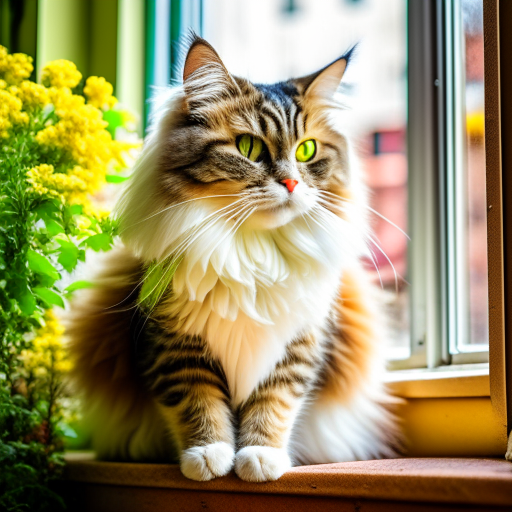

In [10]:
with store:
  # Fetch the invokable associated with the original invocation
  orig_text2image = invocation.request().invokable()
  # Confirm that the system prompt does not contain the example:
  print(orig_text2image.prompt_refiner.system_prompt)
  # Run it to create an old-school cat image.
  output = orig_text2image.invoke(prompt).get_output()
output

Once we're happy with our image generation pipeline, we can deploy it, for
example using the enact.gradio integration:

In [12]:
import enact.gradio

with store:
  enact.gradio.GUI(enact.commit(text2image)).launch()

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
